<h1>
<center>Predicting Housing Prices</center>
</h1>

<h1>
<center>Avery Lee</center>
</h1>

# 1. Preprocessing housing data

In [1]:
import os
import tarfile
from six.moves import urllib
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

HOUSING_PATH = os.path.join("datasets", "housing")

def fetch_housing_data(housing_url, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

HOUSING_URL = ("https://raw.githubusercontent.com/ageron/"+
               "handson-ml2/master/datasets/housing/housing.tgz")
fetch_housing_data(HOUSING_URL)
data = load_housing_data()
data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


Next, we create stratified test and training sets based on different income categories.

In [2]:
data["income_cat"] = np.ceil(data["median_income"] / 1.5)
data["income_cat"].where(data["income_cat"] < 5, 5.0, inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]
    
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [3]:
print(strat_train_set.shape, strat_test_set.shape)

(16512, 10) (4128, 10)


Let us separate the features (`X_raw`) and the response variable (`y`).

In [4]:
X_raw = strat_train_set.drop("median_house_value", axis=1)
y = strat_train_set["median_house_value"].copy()
print(X_raw.shape, y.shape)

(16512, 9) (16512,)


## Handling missing values

Let's find out if there are any missing values in our features. As the code below indicates, out of 16512 observations, 158 have missing values. Further inspection shows that `total_bedrooms` has missing values (only a few missing values are shown below).

In [5]:
X_raw.shape

(16512, 9)

In [6]:
X_raw[X_raw.isnull().any(axis=1)].shape

(158, 9)

In [7]:
incomplete_rows = X_raw[X_raw.isnull().any(axis=1)]
incomplete_rows.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


Let's do some data cleaning. Use the `sklearn.impute.SimpleImputer` class to fill the missing values in the numerical features (all the columns except `ocean_proximity`) with the median of the corresponding feature.

In [8]:
from sklearn.impute import SimpleImputer 

imputer = SimpleImputer(strategy='median')
X_raw_num = X_raw.drop('ocean_proximity', axis=1) # only on numerical values
imputer.fit(X_raw_num)
X = imputer.transform(X_raw_num)
X_clean = pd.DataFrame(X, columns=X_raw_num.columns, index=X_raw.index)
X_clean.loc[incomplete_rows.index.values] # check to see the NaN values have become the median 
X_clean.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


## Handling categorical features
ML algorithms generally work with numerical values. So, we need to convert categorical features to numerical values. One way is to simply map each category to an integer. Another alternative is to use **one-hot encoding**.

Let's do some data cleaning for categorical attributes. We can use the `sklearn.preprocessing.OrdinalEncoder` class and the `sklearn.preprocessing.OneHotEncoder` class to transform the `ocean_proximity` feature to integers and one-hot vectors. 

ANSWER: Ordinal encoding assigns the category values like 0, 1, 2, ..., while one-hot encoding creates a list for each row that indicates which category it is with 0 (false) and 1 (true) like [1,0,0,0,0], [0,1,0,0,0], ... . It is more appropriate to use one-hot encoding because the categories do not have numerical significance. For example, 'INLAND' is not "smaller" than 'NEAR BAY'. But assigning them 1 and 3 for example might impact the model's results as these numbers inherently have order.

In [9]:
from sklearn.preprocessing import OrdinalEncoder 

housing_cat = X_raw[['ocean_proximity']] # the col with categorical values 
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat) # categories become 0, 1, 2, 3, 4

from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_onehot = cat_encoder.fit_transform(housing_cat) # categories become [1,0,0,0,0], [0,1,0,0,0], ..., [0,0,0,0,1]
housing_cat_onehot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Feature scaling

Many ML algorithms do not perform well if the features have different scales (some very small, and others very large). In such scenarios, one should transform the features so that they have similar range of values. There are two common ways to achieve this. In **min-max** scaling, we subtract the feature from its minimum value and then divide by its range (i.e. maximum value minus minimum value) so that the scaled values are between 0 and 1. In **standardization**, we subtract the values from the average and divide by the standard deviation, so that the transformed values has mean 0 and variance 1.

We can use the `sklearn.preprocessing.MinMaxScaler` class and `sklearn.preprocessing.StandardScaler` class to scale the numerical features using min-max scaling and standardization.

In [10]:
from sklearn.preprocessing import MinMaxScaler 

minmaxscaler = MinMaxScaler()
minmaxscaler.fit(X_clean)
X_clean_minmax = pd.DataFrame(minmaxscaler.transform(X_clean), columns=X_clean.columns, index=X_clean.index)

from sklearn.preprocessing import StandardScaler

standardscaler = StandardScaler()
standardscaler.fit(X_clean)
X_clean_standard = pd.DataFrame(standardscaler.transform(X_clean), columns=X_clean.columns, index=X_clean.index)

print(X_clean_minmax.head())
print(X_clean_standard.head())

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655   0.287849  0.635494            0.549020     0.098362        0.128061   
15502   0.709163  0.058448            0.117647     0.135168        0.137403   
2908    0.528884  0.300744            0.843137     0.041003        0.049613   
14053   0.719124  0.022317            0.450980     0.047591        0.083280   
20496   0.562749  0.184910            0.509804     0.089790        0.103737   

       population  households  median_income  
12655    0.062614    0.131441       0.115426  
15502    0.056392    0.143017       0.402574  
2908     0.018610    0.055639       0.163798  
14053    0.025085    0.089806       0.119067  
20496    0.051403    0.107916       0.275617  
       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655  -0.941350  1.347438            0.027564     0.584777        0.640371   
15502   1.171782 -1.192440           -1.722018     1.261467        0.781561   
2908  

## Transformation pipelines

Usually, we have to perform several steps before the data is ready to be fed to an ML algorithm. Scikit-Learn's `Pipeline` class provides a systematic way of "packaging" such a sequence of transformations.

We can create one pipeline that applies the transformations from earlier, to the "raw" features `X_raw`. The transformed data is called `X`.

In [11]:
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

num_attribs = list(X_raw_num.columns)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([('num', num_pipeline, num_attribs), ('cat', OneHotEncoder(), cat_attribs)])
X = full_pipeline.fit_transform(X_raw)
cols = list(X_raw_num.columns) + ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
X = pd.DataFrame(X, columns=cols, index=X_raw.index)
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
12655,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647,0.0,1.0,0.0,0.0,0.0
15502,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168,0.0,0.0,0.0,0.0,1.0
2908,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434,0.0,1.0,0.0,0.0,0.0
14053,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929,0.0,0.0,0.0,0.0,1.0
20496,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752,1.0,0.0,0.0,0.0,0.0


# Fine-tuning models 

## Linear regression 

We can use the `sklearn.linear_model.LinearRegression` class to fit a linear regression to the training set. Use the processed features `X` that was obtained as predictors and `y` (the median house values) as the response. 

In [12]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_train_pred = lin_reg.predict(X)
lin_train_pred[:10] # first 10 predictions on the training set 

array([ 88983.14806384, 305351.35385026, 153334.71183453, 184302.55162102,
       246840.18988841, 208983.6813477 , 375046.02067267, 270259.898592  ,
       153462.62515736,  12077.73402934])

## RMSE and MAE 

We can measure the out-of-sample performance with root mean square error (RMSE) and mean absolute error (MAE). 

We can use `mean_squared_error` and `mean_absolute_error` functions from `sklearn.metrics` to calculate the in-sample RMSE and MAE of the linear regression.

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

lin_train_rmse = np.sqrt(mean_squared_error(y, lin_train_pred))
lin_train_mae = mean_absolute_error(y, lin_train_pred)

print('Train RMSE: ' + str(lin_train_rmse) + ', Train MAE: ' + str(lin_train_mae))

Train RMSE: 69050.56219504567, Train MAE: 49905.329442715316


## Cross validation

We  have evaluated the in-sample performance of the linear regression model. To obtain out-of-sample performance, we use K-fold cross validation.

Nown let's use the `cross_val_score` function from `sklearn.model_selection` to perform 10-fold cross validation on the linear regression and return the values of **RMSE**. Return the 10 RMSE scores as well as their mean.

In [14]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, X, y, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
print('RMSE Scores: ' + str(lin_rmse_scores) + ', Mean: ' + str(lin_rmse_scores.mean()))

RMSE Scores: [72229.03469752 65318.2240289  67706.39604745 69368.53738998
 66767.61061621 73003.75273869 70522.24414582 69440.77896541
 66930.32945876 70756.31946074], Mean: 69204.32275494764


## Alternatives to linear regression 

Let's consider fitting two alternative models, namely, **decision trees** and **random forests**. The following code fits a decision tree and obtains the fitted response for the first 10 observations.

In [15]:
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X,y)

DecisionTreeRegressor(random_state=42)

In [16]:
dt_pred = dt_reg.predict(X)
dt_pred[:10]

array([ 72100., 279600.,  82700., 112500., 238300., 165700., 412300.,
       349600., 181300., 500001.])

The following code does the same for the random forest model.

In [17]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(bootstrap=True, n_estimators=100, max_depth=5, random_state=42)
rf_reg.fit(X, y)

RandomForestRegressor(max_depth=5, random_state=42)

In [18]:
rf_pred = rf_reg.predict(X)
rf_pred[:10]

array([ 81652.52309416, 312816.43220775, 103956.26879436, 145669.10673902,
       254963.91541844, 223471.15507845, 359454.5338993 , 261250.07064825,
       178062.03642388, 152509.12871198])

Find the in-sample performance of the decision tree and the random forest using RMSE on the training set. Also, find the out-of-sample performance by 10-fold cross validation.

As we can see below, the Decision Tree model has the best in-sample performance and Random Forest has the best out-of-sample performance. Lower RMSE means better performance. 

In [19]:
# in-sample RMSE 
dt_rmse = np.sqrt(mean_squared_error(y, dt_pred))
rf_rmse = np.sqrt(mean_squared_error(y, rf_pred))

print('IN-SAMPLE: Linear RMSE: ' + str(lin_train_rmse) + ', Decision Tree RMSE: ' + str(dt_rmse) + ', Random Forest RMSE: ' + str(rf_rmse))

IN-SAMPLE: Linear RMSE: 69050.56219504567, Decision Tree RMSE: 0.0, Random Forest RMSE: 66750.70697525762


In [20]:
# out-of-sample RMSE (cross validation)
dt_scores = cross_val_score(dt_reg, X, y, scoring='neg_mean_squared_error', cv=10)
dt_rmse_scores = np.sqrt(-dt_scores)
rf_scores = cross_val_score(rf_reg, X, y, scoring='neg_mean_squared_error', cv=10)
rf_rmse_scores = np.sqrt(-rf_scores)
print(f'MEAN OF OUT-OF-SAMPLE: Linear RMSE: {lin_rmse_scores.mean()}, Decision Tree RMSE : {dt_rmse_scores.mean()}, Random Forest RMSE: {rf_rmse_scores.mean()}')

MEAN OF OUT-OF-SAMPLE: Linear RMSE: 69204.32275494764, Decision Tree RMSE : 69081.361562518, Random Forest RMSE: 68005.93062180877


## Choosing optimal values of hyperparameters using cross validation

Most ML algorithms have **hyperparameters**. These hyperparameters control the learning process and should not be confused with the model parameters (which are the unknown values that are being estimated). For example, the random forest algorithm has 3 hyperparameters, namely `bootstrap`, `n_estimators`, and `max_depth`. To fine-tune a model, we should find good values of the hyperparameters based on out-of-sample performance.

Let's try using the `sklearn.model_selection.GridSearchCV` class to choose the best hyperparameter values for `bootstrap` over the values `True`, `False`; `n_estimators` over the values 50, 100, 200; and `max_depth` over the values 5, 20, 40. Use 4-fold cross-validation with RMSE when searching for the hyperparameters.

Next, use the `sklearn.model_selection.RandomizedSearchCV` class to perform a randomized search over the same ranges with 18 parameter settings sampled, that is `bootstrap` is `True` or `False` with equal probability, `n_estimators` is a uniform random integer between 50 and 200, `max_depth` is a uniform random integer between 5 and 40. `RandomizedSearchCV` must include the argument `random_state=42`.

In both functions, you may use the argument `n_jobs=-1` to use all avaliable processor cores to speed up the calculation. 

We can see the below grid searching has best hyperparameters of {'bootstrap': True, 'max_depth': 40, 'n_estimators': 200} and random search has best hyperparameters of {'bootstrap': True, 'max_depth': 28, 'n_estimators': 166}. We can see below that with these hyperparameters, grid search has lower RMSE. 

In [21]:
from sklearn.model_selection import GridSearchCV

# bootstrap try True/False (2), n_estimators try 50/100/200 (3), max_depth try 5/20/40 (3) --> 2x3x3=18
param_grid = [{'bootstrap': [True, False],
               'n_estimators': [50,100,200],
               'max_depth': [5,20,40]}]

forest_reg = RandomForestRegressor(random_state=42)
# train across 4 folds, that's a total of 18x4=72 rounds of training 
grid_search = GridSearchCV(forest_reg, 
                           param_grid, 
                           cv=4, 
                           scoring='neg_mean_squared_error', 
                           return_train_score=True, 
                           n_jobs=-1)
grid_search.fit(X, y)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
print('BEST PARAMS: ' + str(grid_search.best_params_))

68126.05103043518 {'bootstrap': True, 'max_depth': 5, 'n_estimators': 50}
68038.32198863207 {'bootstrap': True, 'max_depth': 5, 'n_estimators': 100}
67992.20590489656 {'bootstrap': True, 'max_depth': 5, 'n_estimators': 200}
50847.09322989613 {'bootstrap': True, 'max_depth': 20, 'n_estimators': 50}
50517.386434208776 {'bootstrap': True, 'max_depth': 20, 'n_estimators': 100}
50325.531868775004 {'bootstrap': True, 'max_depth': 20, 'n_estimators': 200}
50765.78093646687 {'bootstrap': True, 'max_depth': 40, 'n_estimators': 50}
50475.98181404633 {'bootstrap': True, 'max_depth': 40, 'n_estimators': 100}
50271.12629517273 {'bootstrap': True, 'max_depth': 40, 'n_estimators': 200}
71083.11760324877 {'bootstrap': False, 'max_depth': 5, 'n_estimators': 50}
71078.93294093257 {'bootstrap': False, 'max_depth': 5, 'n_estimators': 100}
71079.3116002859 {'bootstrap': False, 'max_depth': 5, 'n_estimators': 200}
67109.74630197707 {'bootstrap': False, 'max_depth': 20, 'n_estimators': 50}
67063.47951883342 

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'bootstrap': [True, False], 
                  'n_estimators': randint(low=50, high=200),
                  'max_depth': randint(low=5, high=40)}

rnd_search = RandomizedSearchCV(forest_reg, 
                                param_distributions=param_distribs, 
                                n_iter=18, 
                                cv=4, 
                                scoring='neg_mean_squared_error', 
                                random_state=42, 
                                n_jobs=-1)
rnd_search.fit(X, y)

cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
print('BEST PARAMS: ' + str(rnd_search.best_params_))

50631.36528915277 {'bootstrap': True, 'max_depth': 33, 'n_estimators': 64}
52340.8946928581 {'bootstrap': True, 'max_depth': 12, 'n_estimators': 70}
50380.030436623914 {'bootstrap': True, 'max_depth': 23, 'n_estimators': 124}
50273.28602841223 {'bootstrap': True, 'max_depth': 28, 'n_estimators': 166}
67447.74692166447 {'bootstrap': False, 'max_depth': 28, 'n_estimators': 180}
68465.03714105087 {'bootstrap': False, 'max_depth': 6, 'n_estimators': 137}
67525.4930600352 {'bootstrap': False, 'max_depth': 34, 'n_estimators': 87}
67476.1281683955 {'bootstrap': False, 'max_depth': 25, 'n_estimators': 107}
67520.0131623892 {'bootstrap': False, 'max_depth': 29, 'n_estimators': 98}
50609.391799744895 {'bootstrap': True, 'max_depth': 32, 'n_estimators': 64}
66076.51935679585 {'bootstrap': False, 'max_depth': 7, 'n_estimators': 100}
50362.85253370906 {'bootstrap': True, 'max_depth': 25, 'n_estimators': 122}
50319.065489304085 {'bootstrap': True, 'max_depth': 22, 'n_estimators': 181}
50812.40558997

## Evaluating your final model using the test set

The last step of a ML project is to evaluate your (fine-tuned) model using the test set. The goal of this step is to estimate the out-of-sample performance of your trained model on new data. 

Based on the training RMSE, 50,271.12629517273 (grid) < 50,580.59239131953 (random) so we can pick grid search to be a better model for now. The test RMSE below also say that grid is better because RMSE is lower. 

In [23]:
# preprocess testing data 
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

# pick best models 
grid_search_final_model = grid_search.best_estimator_
rnd_search_final_model = rnd_search.best_estimator_

# predictions 
grid_test_pred = grid_search_final_model.predict(X_test_prepared)
rnd_test_pred = rnd_search_final_model.predict(X_test_prepared)

# rmse 
grid_final_rmse = np.sqrt(mean_squared_error(y_test, grid_test_pred))
rnd_final_rmse = np.sqrt(mean_squared_error(y_test, rnd_test_pred))

print(f'Grid final RMSE: {grid_final_rmse}, Random final RMSE: {rnd_final_rmse}')

/Users/averylee/opt/miniconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/averylee/opt/miniconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Grid final RMSE: 47074.669205115606, Random final RMSE: 47092.139318931426


# Regularizing linear regression

## Polynomial regression and regularizing 

Let's try to fit a model that adds degree 3 polynomial terms to the linear regression from earlier. Next, regularize the model using ridge regression with parameter $\alpha=1$.

In [24]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_features.fit_transform(X)
lin_reg_poly = LinearRegression()
lin_reg_poly.fit(X_poly, y)

from sklearn.linear_model import Ridge 
ridge_reg = Ridge(alpha=1, random_state=42)
ridge_reg.fit(X_poly, y)

Ridge(alpha=1, random_state=42)

In [25]:
# RMSE 
poly_pred = lin_reg_poly.predict(X_poly)
poly_ridge_pred = ridge_reg.predict(X_poly)
print(np.sqrt(mean_squared_error(y, poly_pred)), np.sqrt(mean_squared_error(y, poly_ridge_pred)))

54638.79025341923 55020.03369963052


## Learning curves

Let's plot learning curves for the linear regression model, the polynomial regression model, and the ridge regression model. 

As we can see below, the linear regression model might be underfitting because the training and validation error are approximately very similar and level out at relatively higher error compared to the other two models. The polynomial regression model and ridge regression model seem to be fitting better and are not underfitting or overfitting too much.

In [26]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y, stepsize=1):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    ms = []
    for m in range(stepsize, len(X_train), stepsize):
        ms.append(m)
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        
    plt.plot(ms, np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(ms, np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)


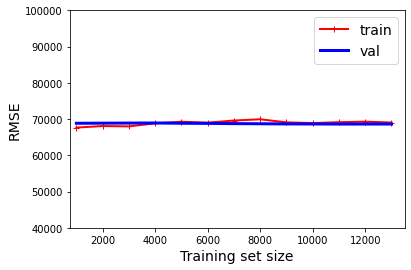

In [27]:
plot_learning_curves(lin_reg, X, y, 1000)
plt.axis([750, 13500, 40000, 100000])
plt.show()

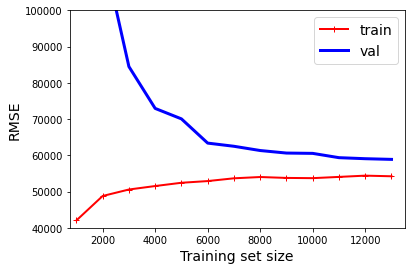

In [28]:
plot_learning_curves(lin_reg_poly, X_poly, y, 1000)
plt.axis([750, 13500, 40000, 100000])
plt.show() 

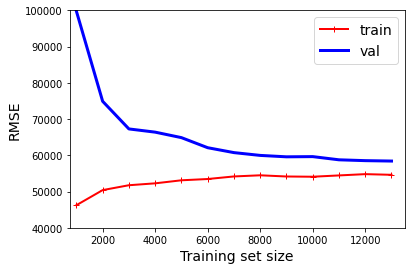

In [29]:
plot_learning_curves(ridge_reg, X_poly, y, 1000)
plt.axis([750, 13500, 40000, 100000])
plt.show()